# [Advanced] Cohort Analysis - Customer Segmentation (2)

Suppose that we have a company that selling some of the product, and you want to know how well does the selling performance of the product.

You have the data that can we analyze, but what kind of analysis that we can do?
Well, we can segment customers based on their buying behavior on the market.
Keep in mind that the data is really huge, and we can not analyze it using our bare eye. We will use machine learning algorithms and the power of computing for it.
This article will show you how to cluster customers on segments based on their behavior using the K-Means algorithm in Python.
I hope that this article will help you on how to do customer segmentation step-by-step from preparing the data to cluster it.

# 1.0 Import Libraries and Load Data

We will be using the Real-world transactions dataset. 

It contains about 500,000 transaction records occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail

Dataset can be downloaded [Here](https://www.kaggle.com/carrie1/ecommerce-data/)

In [1]:
import gc
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import datetime as dt
from datetime import *
from collections import defaultdict

In [2]:
pwd

'/home/bhj623/code/Python-Projects/GeneralML/Cohort_Basket_Analysis'

In [3]:
# Import The Dataset
df = pd.read_csv("/home/bhj623/code/Python-Projects/GeneralML/data/retail.csv", encoding = "ISO-8859-1")

df = df[df['CustomerID'].notna()]

df_fix = df.copy()

# Sample the dataset (if want to test a sample)
# df_fix = df.sample(10000, random_state = 623)

In [4]:
df_fix.shape

(406829, 8)

In [5]:
df_fix.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
df_fix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


# 2.0 Create Recency-Frequency-Monetary (RFM) table

After we sample the data, we will make the data easier to conduct an analysis.

To segmenting customer, there are some metrics that we can use, such as when the customer buy the product for last time, how frequent the customer buy the product, and how much the customer pays for the product. We will call this segmentation as RFM segmentation.

To make the RFM table, we can create these columns, such as Recency, Frequency, and MonetaryValue column.

In [8]:
# Convert 'InvoiceDate' from object to datetime format and show date only
df_fix['InvoiceDate'] = pd.to_datetime(df_fix['InvoiceDate'])
df_fix["InvoiceDate"] = df_fix["InvoiceDate"].dt.date

# Create TotalSum colummn
df_fix["TotalSum"] = df_fix["Quantity"] * df_fix["UnitPrice"]

# Create date variable that records recency
snapshot_date = max(df_fix.InvoiceDate) + timedelta(days=1)

# Aggregate data by each customer
customers = df_fix.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

# Rename columns
customers.rename(columns = {'InvoiceDate': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)

In [9]:
customers.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,2,0.00
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40


# 3.0 Preprocess the dataset (skewedness and scale) 

### 3.1 Manage Skewedness

The current visualizations of each variable is:

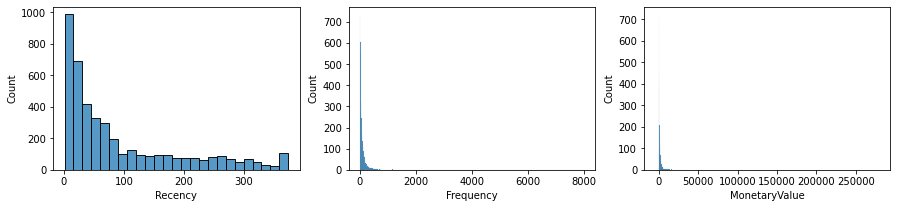

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15,3))
sns.histplot(customers['Recency'], ax=ax[0])
sns.histplot(customers['Frequency'], ax=ax[1])
sns.histplot(customers['MonetaryValue'], ax=ax[2])
plt.show()

As we can see, the data is highly skewed and it should meet assumptions where the variables are not skewed and have the same mean and variance.

There are some methods that we can use to manage the skewness, they are,
1. log transformation
2. square root transformation
3. box-cox transformation

Below are the visualization each variable and with and without transformations. 

From top left clockwise on each variable, each are 
- Origianl Plot
- log transformation 
- square root transformation
- box-cox transformation.

In [16]:
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.histplot(customers[x], ax=ax[0,0])
    sns.histplot(np.log(customers[x]), ax=ax[0,1])
    sns.histplot(np.sqrt(customers[x]), ax=ax[1,0])
    sns.histplot(stats.boxcox(customers[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
    print(customers[x].skew().round(2))
    print(np.log(customers[x]).skew().round(2))
    print(np.sqrt(customers[x]).skew().round(2))
    print(pd.Series(stats.boxcox(customers[x])[0]).skew().round(2))

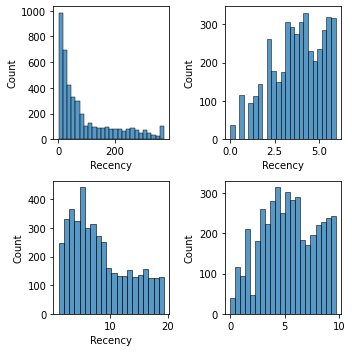

1.25
-0.45
0.6
-0.07


In [17]:
analyze_skewness('Recency')

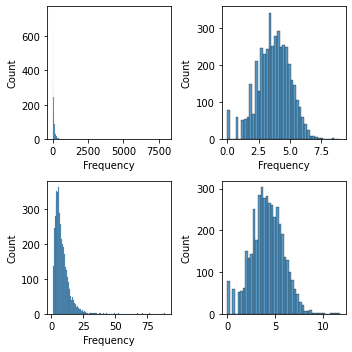

18.15
-0.24
3.2
0.0


In [18]:
analyze_skewness('Frequency')

#### Here is how to interpret the skewness value. 

If the value is close to 0, the variable tend to have symmetrical form. However, if it’s not, the variable has skew on it. Based on that calculation, we use variables that use box-cox transformations.

Based on that calculation, we will utilize variables that use **box-cox transformations**. Except for the MonetaryValue variable because the variable includes negative values. To handle this variable, we can use cubic root transformation to the data, so the comparison looks like this,

/home/bhj623/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bhj623/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


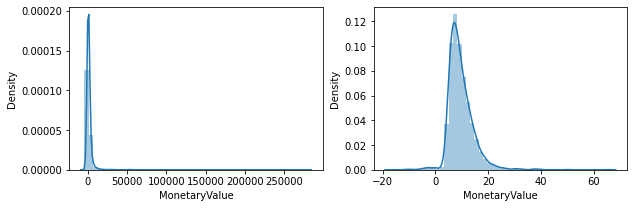

21.71
2.29


In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
sns.distplot(customers['MonetaryValue'], ax=ax[0])
sns.distplot(np.cbrt(customers['MonetaryValue']), ax=ax[1])
plt.show()
print(customers['MonetaryValue'].skew().round(2))
print(np.cbrt(customers['MonetaryValue']).skew().round(2))

In [20]:
pd.Series(np.cbrt(customers['MonetaryValue'])).values

array([ 0.        , 16.27392924, 12.15818345, ...,  5.61043971,
       12.79537593, 12.24781024])

### By using the transformation, we will have data that less skewed. The skewness value declines from 16.63 to 1.16. Therefore, we can transform the RFM table with this code,

In [21]:
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
4367,8.932980,2.460908,5.652483
4368,7.949051,2.058202,4.323541
4369,2.449000,2.762414,5.610440
4370,1.544575,8.057611,12.795376
4371,5.087438,4.808490,12.247810


### 3.2 Manage Scale

In [22]:
# Import library
from sklearn.preprocessing import StandardScaler

# Initialize the Object
scaler = StandardScaler()

# Fit and Transform The Data
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)

# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[-0.  0. -0.]
[1. 1. 1.]


In [23]:
pd.DataFrame(customers_normalized).head()

,0,1,2
0,1.606608,-2.098072,-1.925647
1,-1.696240,1.151346,1.330542
2,0.317615,-0.224316,0.507038
3,-0.669146,0.423978,0.488997
4,1.560253,-0.660498,-0.536848


# 4.0 Implement Clustering

Right after we preprocess the data, now we can focus on modelling. To make segmentation from the data, we can use the K-Means algorithm to do this.

K-Means algorithm is an unsupervised learning algorithm that uses the geometrical principle to determine which cluster belongs to the data. By determine each centroid, we calculate the distance to each centroid. Each data belongs to a centroid if it has the smallest distance from the other. It repeats until the next total of the distance doesn’t have significant changes than before.

To make our clustering reach its maximum performance, we have to determine which hyperparameter fits to the data. To determine which hyperparameter is the best for our model and data, we can use the elbow method to decide. The code will look like this,

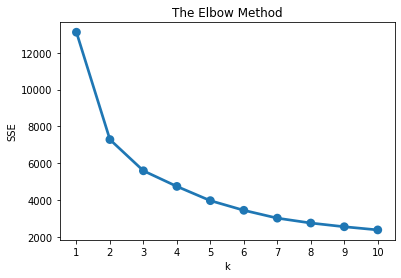

In [24]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

Based on our observation, the **k-value of 3** is the best hyperparameter for our model because the next k-value tend to have a linear trend. Therefore, our best model for the data is K-Means with the number of clusters is **3**

### Train the model with chosen (3) cluster size

In [25]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(4372,)

In [26]:
customers.shape

(4372, 3)

# 5.0 Analyze Clusters

Now we have the right clusters chosen, we can analyze the data. We can summarize the RFM table based on clusters and calculate the mean of each variable.

In [27]:
customers["Cluster"] = model.labels_
customers.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12346.0,326,2,0.00,0
12347.0,3,182,4310.00,2
12348.0,76,31,1797.24,1
12349.0,19,73,1757.55,1
12350.0,311,17,334.40,0


In [28]:
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)
customers.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12346.0,326,2,0.00,0
12347.0,3,182,4310.00,2
12348.0,76,31,1797.24,1
12349.0,19,73,1757.55,1
12350.0,311,17,334.40,0


# 6.0 Visualization

Now we analyze the segments using snake plot. It requires the normalized dataset and also the cluster labels

In [29]:
# Create the dataframe
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_

In [30]:
df_normalized.head()

,Recency,Frequency,MonetaryValue,ID,Cluster
0,1.606608,-2.098072,-1.925647,12346.0,0
1,-1.696240,1.151346,1.330542,12347.0,2
2,0.317615,-0.224316,0.507038,12348.0,1
3,-0.669146,0.423978,0.488997,12349.0,1
4,1.560253,-0.660498,-0.536848,12350.0,0


In [31]:
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')

In [32]:
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,12346.0,0,Recency,1.606608
1,12347.0,2,Recency,-1.696240
2,12348.0,1,Recency,0.317615
3,12349.0,1,Recency,-0.669146
4,12350.0,0,Recency,1.560253


/home/bhj623/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Attribute', ylabel='Value'>

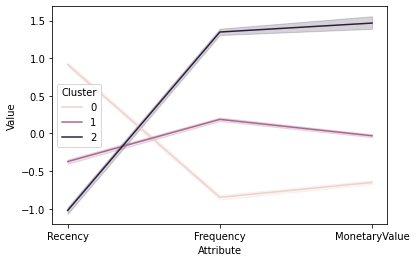

In [33]:
# Visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

# 7.0 Findings

In [34]:
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         185.3      19.2         352.1  1659
1          42.9      67.6        1009.6  1936
2          18.4     314.1        7414.8   777

In [35]:
cluster_avg = customers.groupby('Cluster').mean()
population_avg = customers.mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp

,Cluster,Frequency,MonetaryValue,Recency
Cluster,,,,
0,NaN,-0.793471,-0.814528,1.001280
1,NaN,-0.273349,-0.468192,-0.536536
2,NaN,2.375254,2.905691,-0.801016


### Interpretation
By using this plot, we know how each segment differs. It describes more than we use the summarized table.

1. **The cluster 0** is frequent, spend more, and they buy the product recently. Therefore, it could be the cluster of a loyal customer.

2. **The cluster 1** is less frequent, less to spend, but they buy the product recently. Therefore, it could be the cluster of new customer.

3. **The cluster 2** is less frequent, less to spend, and they buy the product at the old time. Therefore, it could be the cluster of churned customers.

#### References
Daqing C., Sai L.S, and Kun G., Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining (2012), Journal of Database Marketing and Customer Strategy Management.<br>
K. Jarrod Millman and Michael Aivazis. Python for Scientists and Engineers(2011). Computing in Science & Engineering.<br>
https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45<br>
https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/